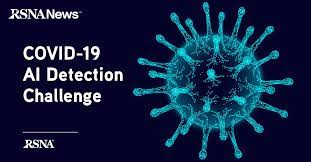

# استدعاء المكتابات المطلوبه للعمل 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import os
import re
import pydicom
import matplotlib.pyplot as plt
import warnings
import pandas_profiling as pp
import glob
import ast
import math
import matplotlib
import wandb
from PIL import Image
import albumentations as A
import torch
import pydicom as dicom
from matplotlib import pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
warnings.filterwarnings("ignore")

# تحميل البيانات


In [ ]:
path = '/kaggle/input/siim-covid19-detection/'

In [ ]:
os.listdir(path)

In [ ]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_df = pd.read_csv(path+'train_study_level.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

# بيان حجم كل ملف من الملفات التى تحتوى على البيانات

In [ ]:
len(sample_submission)

In [ ]:
len(train_image)

# عرض بعض البيانات 

In [ ]:
train_image.head(10)

# عرض معلومات عن بيانات التدريب

In [ ]:
train_image.info()

In [ ]:
train_image.describe()

In [ ]:
train_image.count()

In [ ]:
train_image.isnull()

In [ ]:
temp12 = train_image.loc[0, 'StudyInstanceUID']
temp12

In [ ]:
temp123= train_image.loc[0, 'StudyInstanceUID']
temp123

In [ ]:
boxes =ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

# بناء داله لمستخرج الصوره


**اظهار بعض الصور**

In [ ]:
def extraction(i):
    path_train = path + 'train/' + train_image.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image.loc[i, 'id'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train+img_id)
    img = data_file.pixel_array
    return img

In [ ]:
sample_img = extraction(0)

In [ ]:
sample_img

# اظهار مكان ال **boxes**

In [ ]:
train_image.loc[0, 'boxes']

# عرض بعض  الأمثلة
**لنقوم برسم بعض الأمثلة مع صورة الصدر بالأشعة السينية والمربعات المحيطة والملصق الذى تبينه**

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(sample_img, cmap='gray')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for row in range(9):
    study = train_image.loc[row, 'StudyInstanceUID']
    path_in = path+'train/'+study+'/'
    folder = os.listdir(path_in)
    path_file = path_in+folder[0]
    filename = os.listdir(path_file)[0]
    file_id = filename.split('.')[0]
    
    data_file = dicom.dcmread(path_file+'/'+file_id+'.dcm')
    img = data_file.pixel_array
    if (train_image.loc[row, 'boxes']!=train_image.loc[row, 'boxes']) == False:
        boxes = ast.literal_eval(train_image.loc[row, 'boxes'])
    
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']), box['width'], box['height'],
                                     ec='r', fc='none', lw=2.)
            axs[row].add_patch(p)
    axs[row].imshow(img, cmap='gray')
    axs[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axs[row].set_xticklabels([])
    axs[row].set_yticklabels([])

In [ ]:
label_dict = {0: 'none', 1: 'simple_opacity', 2: 'double_opacity'}
def split_label(s):
    split_string = s.split(' ')
    if len(split_string)==6 and 'none' in split_string:
        return 0
    elif len(split_string)==6 and 'opacity' in split_string:
        return 1
    else:
        return 2

In [ ]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

In [ ]:
train_image['OpacityCount'] = OpacityCount.values
train_image

# لنقوم بتوزيع الفئات الى ثلاث وعرضهم على الرسم


In [ ]:
train_image['OpacityCount'].value_counts().sort_index().rename(label_dict).plot.bar(rot=0, color='orange', alpha=0.6, grid=True, figsize=(8,4), fontsize=16)
plt.show()

In [ ]:
train_df.sum()[1:].plot.bar(rot=45, color='orange', alpha=0.6, grid=True, figsize=(8,4), fontsize=12)
plt.show()

# لنقم بفتحملف test_df

In [ ]:
train_df['id'].isnull().sum()

In [ ]:
train_df['id'].str.split('_')

In [ ]:
import matplotlib.pylab as pylab

# لنقوم هنا بتوزيع السمات الفصل

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 32),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [ ]:
pp.ProfileReport(train_image)